# Exercise 2: Dynamic Mode Decomposition

The DMD is a modal analysis technique that is very commonly used to analyse dynamical systems such as reactive turbulent flows. The objective is to find a linear approximation of the dynamical system such that:

\begin{equation}
    \mathbf{x}_{k+1} = \mathbf{A} \mathbf{x}_{k}.
\end{equation}

The matrix $\mathbf{A}$ advances the state of the system $\mathbf{x}_k$ to the next time $k+1$. In theory, if we split the data matrix $\mathbf{X}$ into $\mathbf{X}_1$ and $\mathbf{X}_2$, where $\mathbf{X}_1$ contains the snapshots from $k=0$ to $k=m-1$ and $\mathbf{X}_2$ contains the snapshots from $k=1$ to $k=m$, we can compute $\mathbf{A}$ as the solution of a least-squares regression problem:

\begin{equation}
    \mathbf{A} = \mathbf{X}_2 \mathbf{X}_1^+,
\end{equation}

where $\mathbf{X}_1^+$ denotes the pseudo-inverse of the matrix $\mathbf{X}_1$. However, the matrix $\mathbf{A}$ has dimensions $n \times n$, meaning that for practial applications it is impossible to directly compute it.

There exist various algorithms to estimate the eigenvectors and eigenvalues of $\mathbf{A}$, which generally rely on the POD to reduce the dimensionality of the problem. We report the "Exact DMD" algorithm from Tu et al. [[2]](https://arxiv.org/pdf/1312.0041.pdf).

## Algorithm 

- Center the dataset by removing the time-average field $\mathbf{X}_0 = \mathbf{X} - \bar{\mathbf{x}}$.

- Split the centered matrix into the matrices $\mathbf{X}_{0,1}$ and $\mathbf{X}_{0,2}$, where $\mathbf{X}_{0,1}$ contains the snapshots from $k=1$ to $k=m-1$ and $\mathbf{X}_{0,2}$ contains the snapshots from $k=2$ to $k=m$.

- Compute the SVD: $\mathbf{X}_{0,1} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T$.

- Compute the approximation: $\widetilde{\mathbf{A}} = \mathbf{U}^T \mathbf{X}_{0,2} \mathbf{V} \boldsymbol{\Sigma}^{-1}$.

- Compute its eigendecomposition: $\widetilde{\mathbf{A}} = \mathbf{W}\boldsymbol{\Lambda}\mathbf{W}^T$. $\boldsymbol{\Lambda}$ contains the DMD eigenvalues.

- Compute the DMD modes $\boldsymbol{\Phi} = \mathbf{X}_{0,2} \mathbf{V} \boldsymbol{\Sigma}^{-1} \mathbf{W}$.

- Compute the amplitude of the modes as $\mathbf{b} = \boldsymbol{\Phi}^{+} \mathbf{x}_{,1}$, where $\mathbf{x}_{0,1}$ is the first snapshot.

- The prediction in time is represented as $\mathbf{x}_k = \boldsymbol{\Phi} \boldsymbol{\Lambda}^{k} \mathbf{b}$ (discrete) or by $\mathbf{x}(t) = \boldsymbol{\Phi} \exp(\boldsymbol{\Omega} t) \mathbf{b}$ (continuous) with $\boldsymbol{\omega} = \log(\boldsymbol{\lambda})/ \Delta t$




## Properties

- As the POD, the DMD decouples the spatial information in $\boldsymbol{\Phi}$ from the temporal information in $\boldsymbol{\Lambda}$.

- The DMD modes are not orthogonal. This means that, for example, the energy content of a group of modes is not the sum of the energy of the single modes, because they can have partially overlapping energy. 

- The identification of the most important modes is not straightforward. Generally, we sort them by the amplitude or by the average energy content.

- The interpretation of modes with a decaying or exploding growth factors is challenging because they could represent either a non-linear physical phenomenon or noise.




In [15]:
# Task 1: center the training matrix and split it into X01 and X02. 
#         Check the shape of the two matrices.

import numpy as np
import matplotlib.pyplot as plt

X = np.load('X_100_r64.npy')
# Use this one on the cluster
# X = np.load('/home/nct00/nct00006/ercoftac2023/X_100_r64.npy') 

resolution = (64, 64)
dt = 1/2500
n, m = X.shape

x_avg = np.mean(X, axis=1)
X0 = X - x_avg[:,  np.newaxis]

X01 = X0[:, :-1]
X02 = X0[:, 1:]

print(f'X01 has shape: {X01.shape}')
print(f'X02 has shape: {X02.shape}')


X01 has shape: (4096, 1023)
X02 has shape: (4096, 1023)


In [16]:
# Task 2: compute the SVD on matrix X01 and invert the matrix Sigma

U, sigma, Vt = np.linalg.svd(X01, full_matrices=False)
V = Vt.T

Sigma_inv = np.diag(1/sigma)

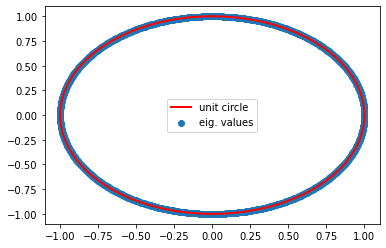

In [17]:
# Task 3: compute the approximation A_tilde and compute its eigendecomposition.
#         plot the eigenvalues on the complex plane and check if they lie on the unity circle.

A_tilde = np.linalg.multi_dot([U.T, X02, V, Sigma_inv])
lamda, W = np.linalg.eig(A_tilde)

theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), c='r', lw=2, label='unit circle')

plt.scatter(np.real(lamda), np.imag(lamda), label='eig. values')
plt.legend()
plt.show()


In [18]:
# Task 4: compute the DMD modes and the amplitudes vector. 
#         Sort the modes and the eigenvectors by the amplitudes (absolute value), in decreasing order.

Phi = np.linalg.multi_dot([X02, V, Sigma_inv, W])
b = np.linalg.pinv(Phi) @ X01[:,0]

i_sort = np.argsort(np.abs(b))[::-1]
b_sort = b[i_sort]
lamda_sort = lamda[i_sort]
Phi_sort = Phi[:, i_sort]


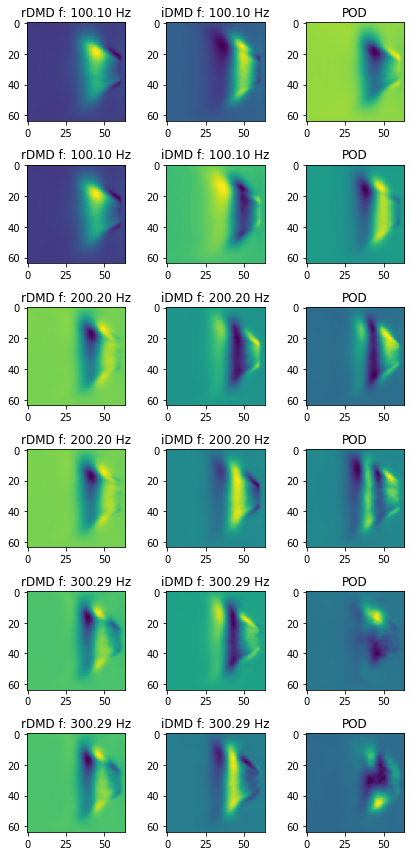

In [24]:
# Task 5: compute the frequency of the modes. Plot the first 6 DMD modes and their frequency.
#         compare them with the first 6 POD modes.

freq = np.abs(np.imag(np.log(lamda_sort)/(2*np.pi*dt)))

U_pod, sigma_pod, Vt_pod = np.linalg.svd(X0, full_matrices=False)

fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(6, 12))
for i in range(6):
    axs[i, 0].imshow(np.real(Phi_sort[:,i]).reshape(resolution))
    axs[i, 0].set_title(f'rDMD f: {np.abs(freq[i]):.2f} Hz')

    axs[i, 1].imshow(np.imag(Phi_sort[:,i]).reshape(resolution))
    axs[i, 1].set_title(f'iDMD f: {np.abs(freq[i]):.2f} Hz')
    
    axs[i, 2].imshow(np.real(U[:,i]).reshape(resolution))
    axs[i, 2].set_title(f'POD')

fig.tight_layout()
plt.show()


The POD reconstruction error is 1.41e+01
The DMD reconstruction error is 5.10e+01


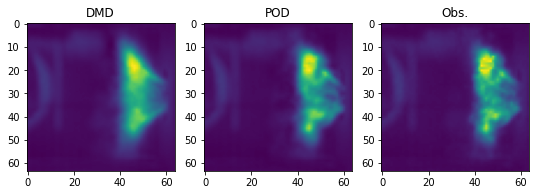

In [20]:
# Task 6: reconstruct the dataset using 128 modes. 
#         Compare the error with the POD reconstruction error using the same number of modes.
#         The reconstruction error is defined as the Frobenius norm of the difference
#         between the observed and reconstructed matrices.

q = 128

Uq_pod = U_pod[:,:q]
sigmaq_pod = sigma_pod[:q]
Vq_pod = np.transpose(Vt_pod)[:,:q]

X_pod_rec = np.linalg.multi_dot([Uq_pod, np.diag(sigmaq_pod), Vq_pod.T]) + x_avg[:, np.newaxis]
error_pod = np.linalg.norm(X_pod_rec-X)

Phiq = Phi_sort[:,:q]
lamdaq = lamda_sort[:q]
bq = b_sort[:q]

X0_dmd_rec = np.zeros((n, m))
for i in range(m):
    X0_dmd_rec[:,i] = np.real(np.linalg.multi_dot([Phiq, np.diag(lamdaq**i), bq]))

X_dmd_rec = X0_dmd_rec + x_avg[:, np.newaxis]
error_dmd = np.linalg.norm(X_dmd_rec-X)

print(f'The POD reconstruction error is {error_pod:.2e}')
print(f'The DMD reconstruction error is {error_dmd:.2e}')

fig, axs = plt.subplots(ncols=3, figsize=(9, 3))
axs[0].imshow(X_dmd_rec[:,-1].reshape(resolution))
axs[0].set_title('DMD')

axs[1].imshow(X_pod_rec[:,-1].reshape(resolution))
axs[1].set_title('POD')

axs[2].imshow(X[:,-1].reshape(resolution))
axs[2].set_title('Obs.')

plt.show()

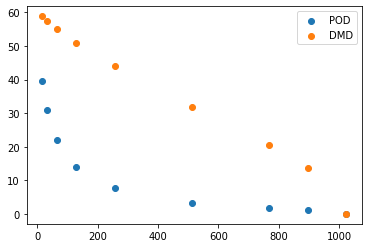

In [21]:
# Task 7: plot the reconstruction error as a function of q for 
#         q = [16, 32, 64, 128, 256, 512, 768, 896, 1024] for both POD and DMD

def POD_error(q):
    Uq_pod = U_pod[:,:q]
    sigmaq_pod = sigma_pod[:q]
    Vq_pod = np.transpose(Vt_pod)[:,:q]

    X_pod_rec = np.linalg.multi_dot([Uq_pod, np.diag(sigmaq_pod), Vq_pod.T]) + x_avg[:, np.newaxis]
    error_pod = np.linalg.norm(X_pod_rec-X)

    return error_pod

def DMD_error(q):
    Phiq = Phi_sort[:,:q]
    lamdaq = lamda_sort[:q]
    bq = b_sort[:q]

    X0_dmd_rec = np.zeros((n, m))
    for i in range(m):
        X0_dmd_rec[:,i] = np.real(np.linalg.multi_dot([Phiq, np.diag(lamdaq**i), bq]))

    X_dmd_rec = X0_dmd_rec + x_avg[:, np.newaxis]
    error_dmd = np.linalg.norm(X_dmd_rec-X)

    return error_dmd

qs = [16, 32, 64, 128, 256, 512, 768, 896, 1024]

errors_pod = np.zeros((len(qs),))
errors_dmd = np.zeros((len(qs),))

for i, q in enumerate(qs):
    errors_pod[i] = POD_error(q)
    errors_dmd[i] = DMD_error(q)


plt.scatter(qs, errors_pod, label='POD')
plt.scatter(qs, errors_dmd, label='DMD')
plt.legend()
plt.show()



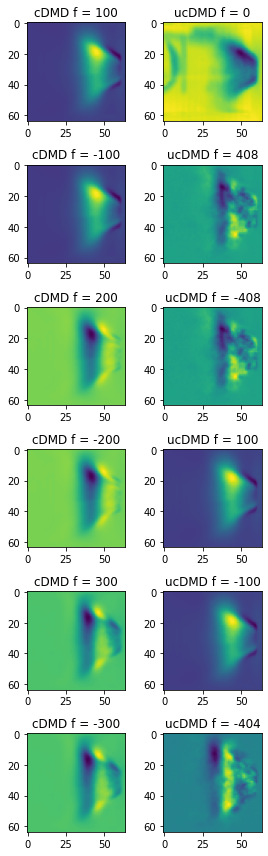

In [23]:
# Task 8: apply the DMD on the uncentered data and compared the uncentered modes with the centered ones

def dmd(X):
    
    X1 = X[:, :-1]
    X2 = X[:, 1:]

    U, sigma, Vt = np.linalg.svd(X1, full_matrices=False)
    V = Vt.T

    Sigma_inv = np.diag(1/sigma)

    A_tilde = np.linalg.multi_dot([U.T, X2, V, Sigma_inv])
    lamda, W = np.linalg.eig(A_tilde)

    Phi = np.linalg.multi_dot([X2, V, Sigma_inv, W])
    b = np.linalg.pinv(Phi) @ X1[:,0]

    i_sort = np.argsort(np.abs(b))[::-1]
    b_sort = b[i_sort]
    lamda_sort = lamda[i_sort]
    Phi_sort = Phi[:, i_sort]

    Phiq = Phi_sort[:,:q]
    lamdaq = lamda_sort[:q]
    bq = b_sort[:q]

    return Phiq, lamdaq, bq

Phi0, lamda0, b0 = dmd(X0)
freq0 = np.abs(np.imag(np.log(lamda0)/(2*np.pi*dt)))

Phi, lamda, b = dmd(X)
freq = np.abs(np.imag(np.log(lamda)/(2*np.pi*dt)))

fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(4, 12))
for i in range(6):
    axs[i, 0].imshow(np.real(Phi0[:,i]).reshape(resolution))
    axs[i, 0].set_title(f'cDMD f = {freq0[i]:.0f}')
    
    axs[i, 1].imshow(np.real(Phi[:,i]).reshape(resolution))
    axs[i, 1].set_title(f'ucDMD f = {freq[i]:.0f}')

fig.tight_layout()
plt.show()

The max growth rate is: 27.687


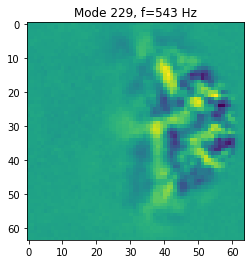

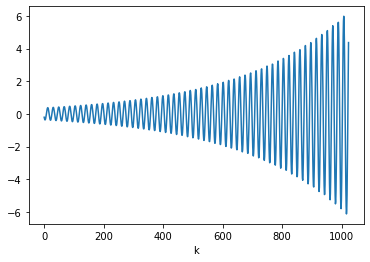

In [12]:
# Task 9: find the uncentered mode with the biggest growth coefficient.
#         plot its temporal behaviour in time from n = 0 to n = 256

i_max = np.argmax(np.real(np.log(lamda)))
omega_max = np.real(np.log(lamda)/(dt))[i_max]
print(f'The max growth rate is: {omega_max:.3f}')
f_max = np.abs(np.imag(np.log(lamda[i_max])/(2*np.pi*dt)))

plt.imshow(np.real(Phi[:,i_max]).reshape(resolution))
plt.title(f'Mode {i_max}, f={f_max:.0f} Hz')
plt.show()

new_timesteps = np.arange(0, 256, step=0.25)
plt.plot(np.real(b[i_max]*lamda[i_max]**new_timesteps))
plt.xlabel('k')
plt.show()